# Tensor Decomposition for high-dimensional Data

In some recent posts, I have outlined some of the important aspects and applications of the Singular Value Decomposition of a matrix (SVD). The SVD, among other matrix decompositions are pervaisive across areas of science and data science. These approaches work extremely well we can organize our data into matrices. There are some cases when cannot do this. When we extend beyond the two dimensions of a matrix, many of our go-to algorithms may not so easily apply. The SVD, for instance, only works to decompose matrices. All is not lost, however. To analyze the signals underlying high-dimensional arrays we can turn to tensor decomposition.

Tensor decomposition works similarly to matrix decomposition in that the goal is to express the original data array as a combination of factors, each expressing different aspects of the data. In this post, we'll examine the Canonical Polyadic Decomposition of a tensor (CPD). Just as the SVD affords different rank r approximations of a matrix, the CPD is rank decomposition for tensors.



- Complications with Tensors
- Tensor Rank
- The Canonical Polyadic Decomposition of a Tensor
- Randomized Tensor Decomposition

## Complications with Tensors



## Tensor Rank


In one of my earlier posts, we looked at an example of a rank 1 matrix and saw that the matrix consisted of the same column over and over again multipled by different values. Similarly for third-order tensors, each 2d slice is a rank 1 matrix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorly
from tensorly.decomposition import parafac
from PIL import Image, ImageOps

In [2]:
### just generating an image of a cube


from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colorbar
import matplotlib.colors

def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z

def plotCubeAt(pos=(0,0,0), c="b", alpha=0.1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=0.1)

def plotMatrix(ax, x, y, z, data, cmap="jet", cax=None, alpha=0.1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    for i, xi in enumerate(x):
            for j, yi in enumerate(y):
                for k, zi, in enumerate(z):
                    plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alpha,  ax=ax)



    if cax !=None:
        cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')  
        cbar.set_ticks(np.unique(data))
        # set the colorbar transparent as well
        cbar.solids.set(alpha=alpha)              


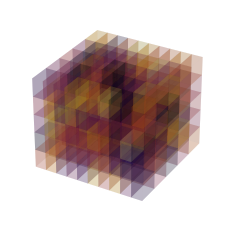

In [3]:
ax = plt.figure().add_subplot(projection='3d')
x = np.array(range(10))
y = np.array(range(10,15))
z = np.array(range(15,20))
data_value = np.random.random((len(x), len(y), len(z)) )
plotMatrix(ax, x, y, z, data_value, cmap='inferno')
ax.axis('off');

In [4]:
np.random.seed(121)
r1 = np.random.normal(0.0, 0.9, size=(4))
r2 = np.random.normal(0.0, 0.9, size=(5))
r3 = np.random.normal(0.0, 0.9, size=(6))

data = np.zeros((4,5,6))
for i,r in enumerate(r3):
    data[:,:,i] = np.outer(r1,r2) * r

#seaborn.heatmap(data);

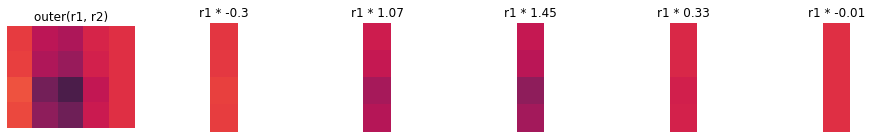

In [5]:
fig, axs = plt.subplots(1, 6, figsize=(16,2))

seaborn.heatmap(ax=axs[0], data=np.outer(r1, r2), cbar=False, square=True, vmin=data.min(), vmax=data.max())
axs[0].set_title('outer(r1, r2)')
axs[0].axis('off')

for i in range(1,6):
    seaborn.heatmap(ax=axs[i], data=data[:,i-1,0][:,None], cbar=False, square=True, vmin=data.min(), vmax=data.max())
    axs[i].set_title(f'r1 * {np.round(r2[i-1],2)}')
    axs[i].axis('off')

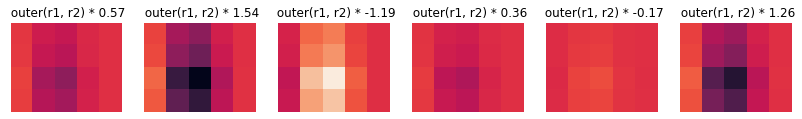

In [6]:
fig, axs = plt.subplots(1, 6, figsize=(14,4))

for i in range(6):
    seaborn.heatmap(ax=axs[i], data=data[:,:,i], cbar=False, square=True, vmin=data.min(), vmax=data.max())
    axs[i].set_title(f' outer(r1, r2) * {np.round(r3[i],2)}')
    axs[i].axis('off')

In [7]:
weights, factors = parafac(data, rank=3, init='random', tol=10e-6)

In [8]:
factors

[array([[ 0.09715526, -0.12976871,  0.03416368],
        [ 0.13055678, -0.17438258,  0.04590899],
        [ 0.26296466, -0.35123765,  0.09246889],
        [ 0.20175357, -0.26947899,  0.07094463]]),
 array([[-4.58928939e-01, -1.24179125e+00, -4.33280874e+00],
        [ 1.64560534e+00,  4.45275542e+00,  1.55363774e+01],
        [ 2.24573668e+00,  6.07661870e+00,  2.12022967e+01],
        [ 5.10300525e-01,  1.38079488e+00,  4.81781468e+00],
        [-1.96290602e-02, -5.31132234e-02, -1.85320550e-01]]),
 array([[ 0.24973797,  0.23475511, -0.03670628],
        [-0.36562228, -0.09257146, -0.57997983],
        [ 0.53198972,  0.03917246,  0.33982975],
        [ 0.00477976, -0.02232315, -0.16427219],
        [-0.05680068, -0.01919635,  0.06219844],
        [-0.04547993, -0.04570737, -0.51997552]])]

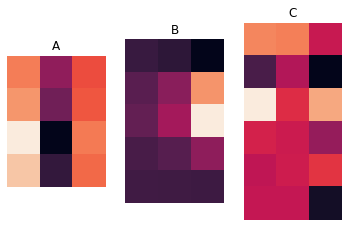

In [9]:
fig, axs = plt.subplots(1,3)

seaborn.heatmap(ax=axs[0], data=factors[0], cbar=False, square=True)
seaborn.heatmap(ax=axs[1], data=factors[1], cbar=False, square=True)
seaborn.heatmap(ax=axs[2], data=factors[2], cbar=False, square=True)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_title('A')
axs[1].set_title('B')
axs[2].set_title('C');

In [10]:
weights

array([1., 1., 1.])

In [11]:
cp_reconstruction = tensorly.cp_to_tensor((weights, factors))

In [13]:
r1, factors[0][:,0]

(array([-0.19082985, -0.25643625, -0.51650839, -0.39627915]),
 array([0.09715526, 0.13055678, 0.26296466, 0.20175357]))

In [14]:
r2, factors[1][:,0]

(array([-0.2970995 ,  1.06532511,  1.45383564,  0.33035622, -0.01270738]),
 array([-0.45892894,  1.64560534,  2.24573668,  0.51030052, -0.01962906]))

## CPD-based Compression

In [15]:
fraya = Image.open('images/td/fraya.jpg')

In [16]:
size = fraya.size
fraya = fraya.resize((int(size[0]/8), int(size[1]/8)))
#fraya.resize((500,500))

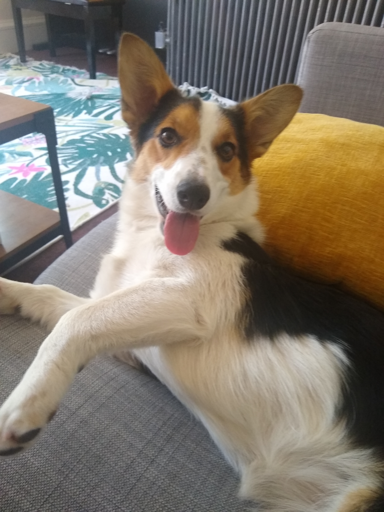

In [17]:
fraya

In [18]:
weights, factors = parafac(np.array(fraya).astype(np.float64), rank=95, init='random', tol=10e-6)

In [19]:
ranks = [1, 5, 10, 25, 50, 100]
low_rank_approximations = []
for r in ranks:
    low_rank_approximations.append(parafac(np.array(fraya).astype(np.float64), rank=r, init='random', tol=10e-6))

Borrowing an example from [Tensorly](http://tensorly.org/stable/auto_examples/decomposition/plot_image_compression.html#sphx-glr-auto-examples-decomposition-plot-image-compression-py)

In [20]:
def to_image(tensor):
    im = tensorly.to_numpy(tensor)
    im -= im.min()
    im /= im.max()
    im *= 255
    return im.astype(np.uint8)

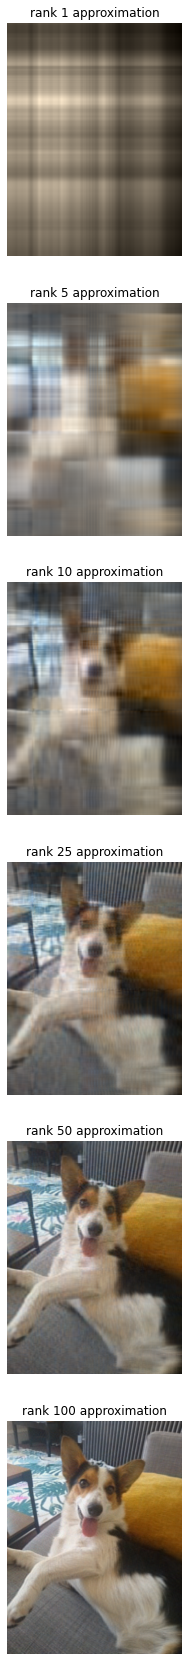

In [21]:
fig, axs = plt.subplots(6, figsize=(20,30))

for i,r in enumerate(ranks):
    cp_reconstruction = tensorly.cp_to_tensor(low_rank_approximations[i])
    axs[i].imshow(to_image(cp_reconstruction))
    axs[i].axis('off')
    axs[i].set_title(f'rank {r} approximation')

## Factor Analysis and 'eigenfeatures'

## Randomized CPD